In [1]:
import numpy as np
import torch
import torch.optim as optim
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/student/2020/cs20btech11028/anaconda3/envs/guided_diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
data = np.load('VIRTUAL_lsun_bedroom256.npz')
# downloaded from https://openaipublic.blob.core.windows.net/diffusion/jul-2021/ref_batches/lsun/bedroom/VIRTUAL_lsun_bedroom256.npz

In [3]:
arr0 = data['arr_0']

## Preprocessing

In [4]:
IMAGE_SHAPE = (32, 32)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [5]:
transformed_images = []

# Iterate through each image in the NumPy array
for img in arr0:
    # print(img.shape)
    img_tensor = transform(img)
    # print(img_tensor.shape)
    # Append the transformed image to the list
    transformed_images.append(img_tensor)

# Convert the list of tensors to a single tensor
transformed_images = torch.stack(transformed_images)


In [6]:
device = 'cuda:2'

In [7]:
transformed_images = transformed_images.to(device=device)
transformed_images = transformed_images[:500]
transformed_images.shape

torch.Size([500, 3, 32, 32])

## Training

In [8]:
model = Unet(
    dim = 32,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
).to(device=device)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000    # number of steps
).to(device=device)

# training_images = transformed_images
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)


losses = []
for e in tqdm(range(5000)):
    # print(e)
    loss = diffusion(transformed_images)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


100%|██████████| 5000/5000 [30:11<00:00,  2.76it/s]


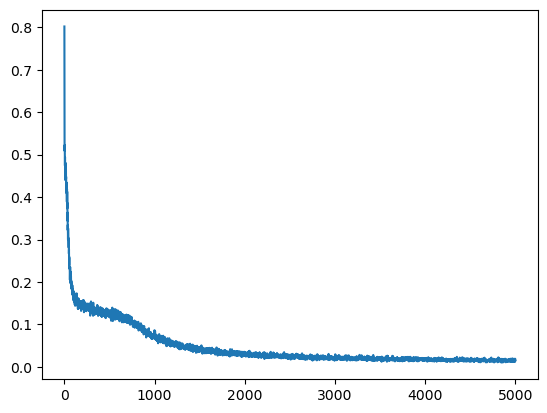

In [9]:
plt.plot(losses)

In [10]:
losses[-1]

0.017184073105454445

## Sampling Images

In [15]:
num_samples = 5
sampled_images = diffusion.sample(batch_size = num_samples)
sampled_images.shape

sampling loop time step: 100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]


torch.Size([5, 3, 32, 32])

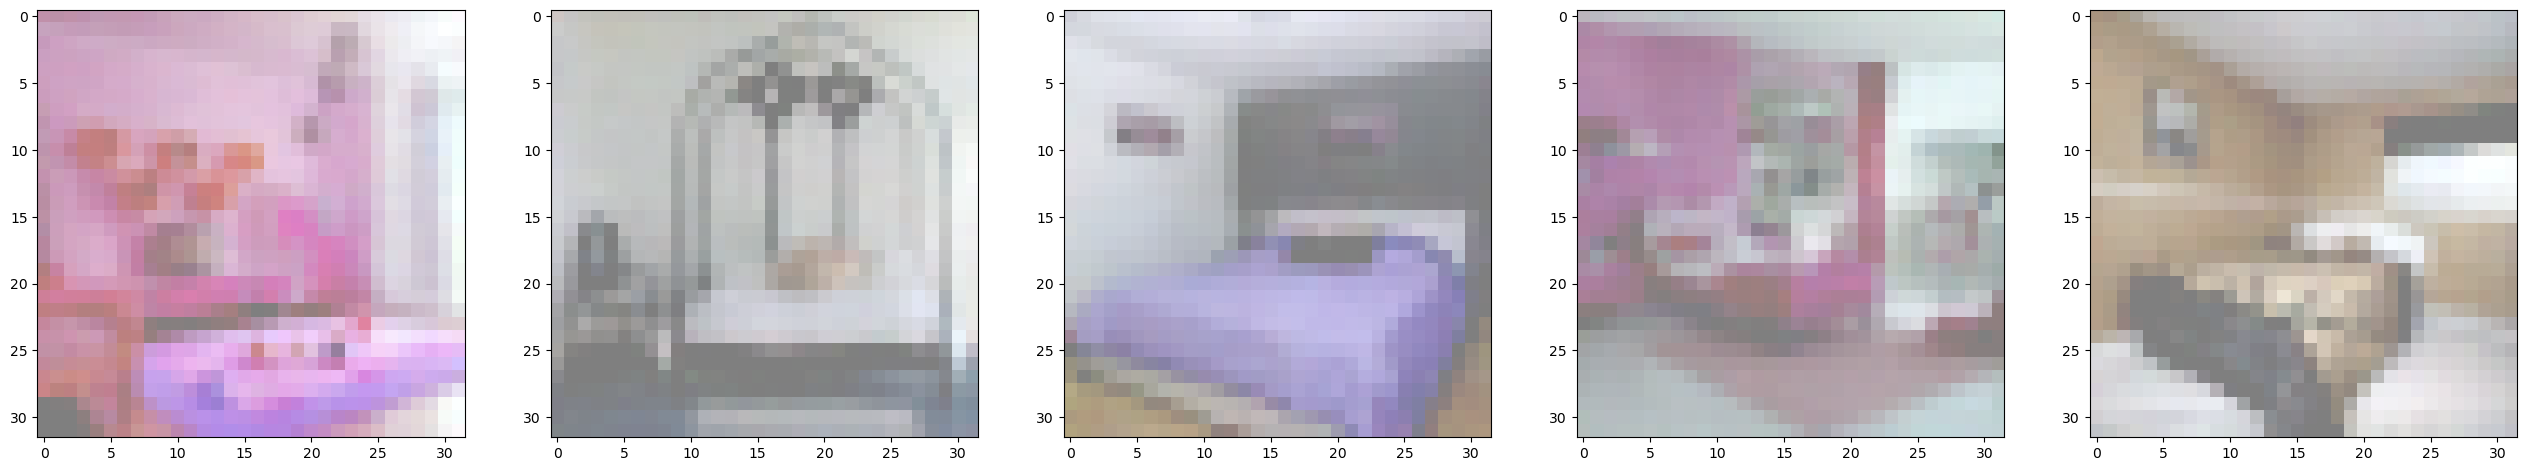

In [17]:
f, ax = plt.subplots(1, num_samples, figsize = (32,32))
for i in range(num_samples):
    ax[i].imshow(reverse_transform(sampled_images[i]))
plt.show()